In [409]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

from sklearn.datasets import load_boston

In [410]:
data = pd.read_csv(load_boston()['filename'], skiprows=1)

In [411]:
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's
print(load_boston()['DESCR'])

проверим состав данных и количество:
    - всего 506 записей, пробелы данных отсутствуют
    - все данные чилсовые, поэтому строки не нужно будет преобразовывать 
    - судя по описанию отсутствуют категориальные признаки (ну если только CHAS и возможно RAD). то есть все величины условно непрерывные

In [412]:
data['CHAS'].value_counts()

0    471
1     35
Name: CHAS, dtype: int64

In [413]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


Проведем экплоративный анализ (проверим статистикческие показатели):
 - почти все параметры не имею нормального распределения
 - много выбросов, особенно B, ZN, CRIM (июют очень слабовыраженную корелляцию в районе 0,33)
 - параметр CHAS категориальный и по хорошему его надо преобразовать с помощью one-hot-encoding

In [414]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


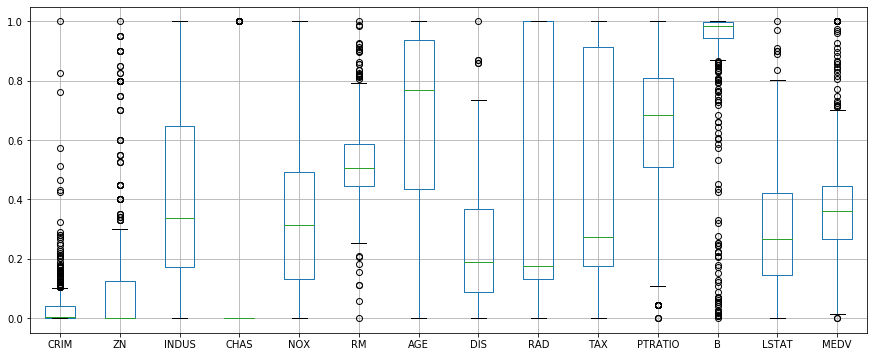

In [415]:
mm_scaler = preprocessing.MinMaxScaler()
mm_X = mm_scaler.fit_transform(data)
bp = pd.DataFrame(mm_X, columns = data.columns)
bp.boxplot(figsize = (15,6))


Распределния у признаков отличаются друг от друга. Только один признак имеет явное нормальное распределение (RM)

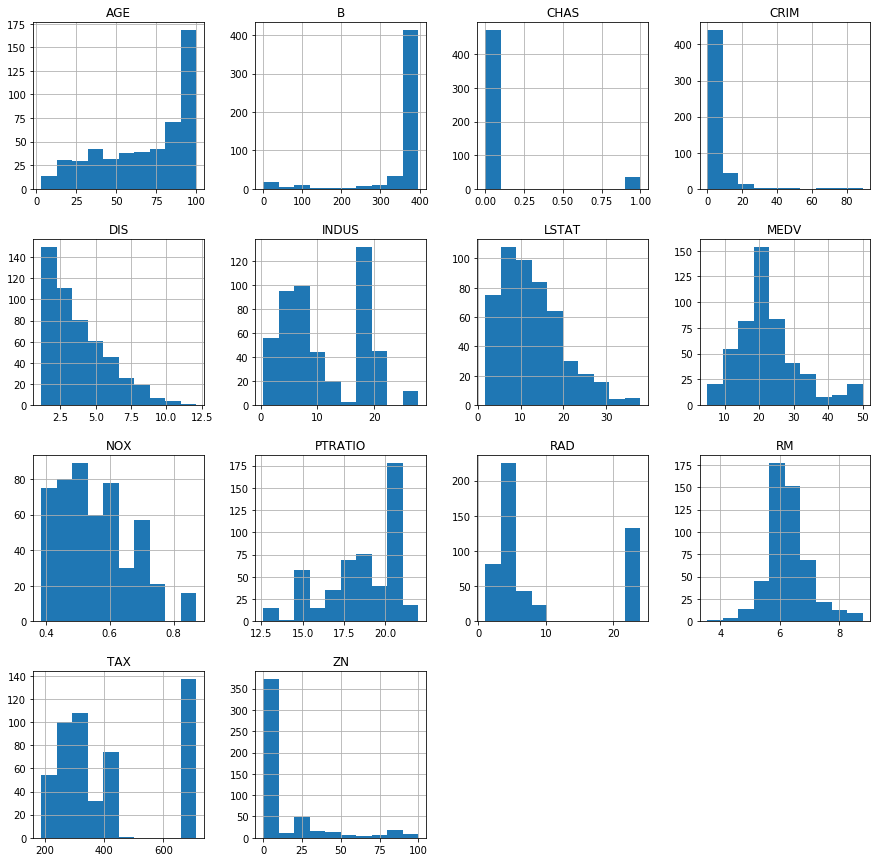

In [416]:
data.hist(figsize = (15,15))
plt.show()

посмотрим на взаимную корелляцию признаков: корреляция только между RAD и TAX. так как это единичный параметр, то смысла удалять один из них нету. Если смотреть корелляцию с целевым показателем, то тут прослеживается небольшая положительная связь с RM (0.7) и обртная с LSTAT (-0.74)

(14.0, 0.0)

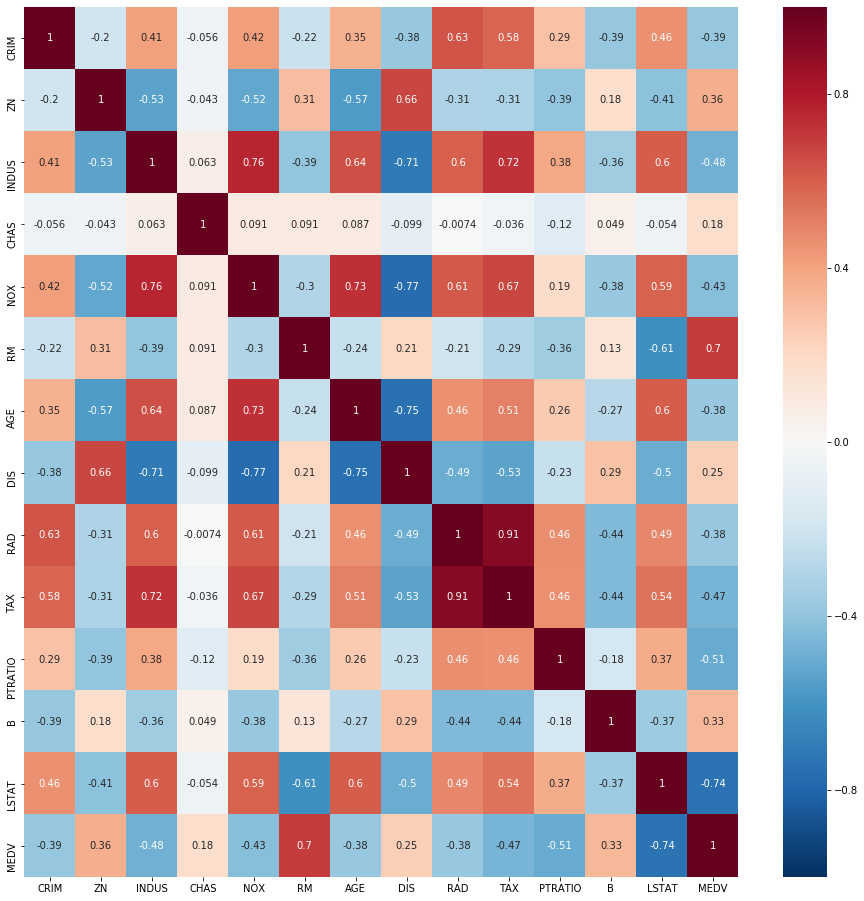

In [417]:
plt.figure(figsize=(16, 16))
ax = sns.heatmap(data.corr(), cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Попробуем выявить связь между параметрами вида 1/x (х - признак) и посмотреть на их корелляцию с оригинальными признаками и целевой переменной MEDV.
Видно, что есть положительная связь с 1/LSTAT (0.8), чтобы было и видно а предыдущем шаге

In [418]:
inverse_data = data.copy()
for col_name in list(data.columns):
    name = col_name + 'inv'
    inverse_data[name] = 1/data[col_name]

(28.0, 0.0)

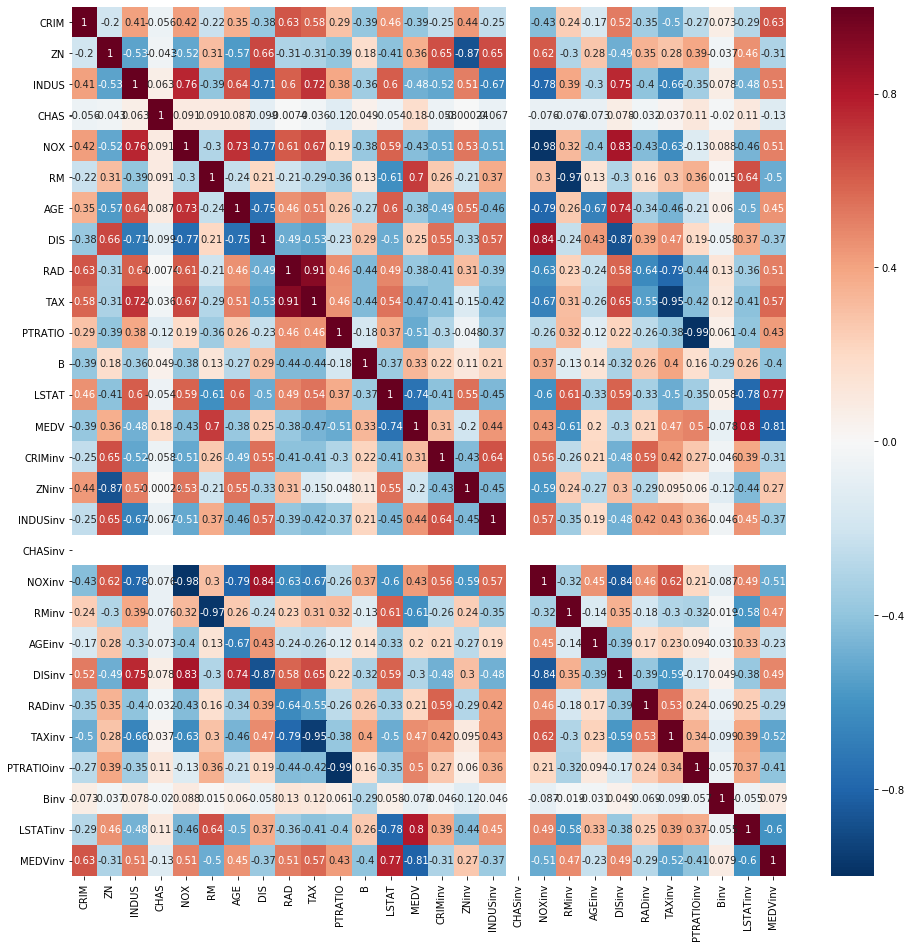

In [419]:
plt.figure(figsize=(16, 16))
ax = sns.heatmap(inverse_data.corr(), cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Попробуем выявить связь между параметрами вида 1/x^2 (х - признак) и посмотреть на их корелляцию с оригинальными признаками и целевой переменной MEDV.
Никаких более-менее сильных связей тут нет, поэтому дальше не будем увеличивать степень.

In [420]:
inverse2_data = data.copy()
for col_name in list(data.columns):
    name = col_name + 'inv2'
    inverse2_data[name] = 1/(data[col_name]*data[col_name])

(28.0, 0.0)

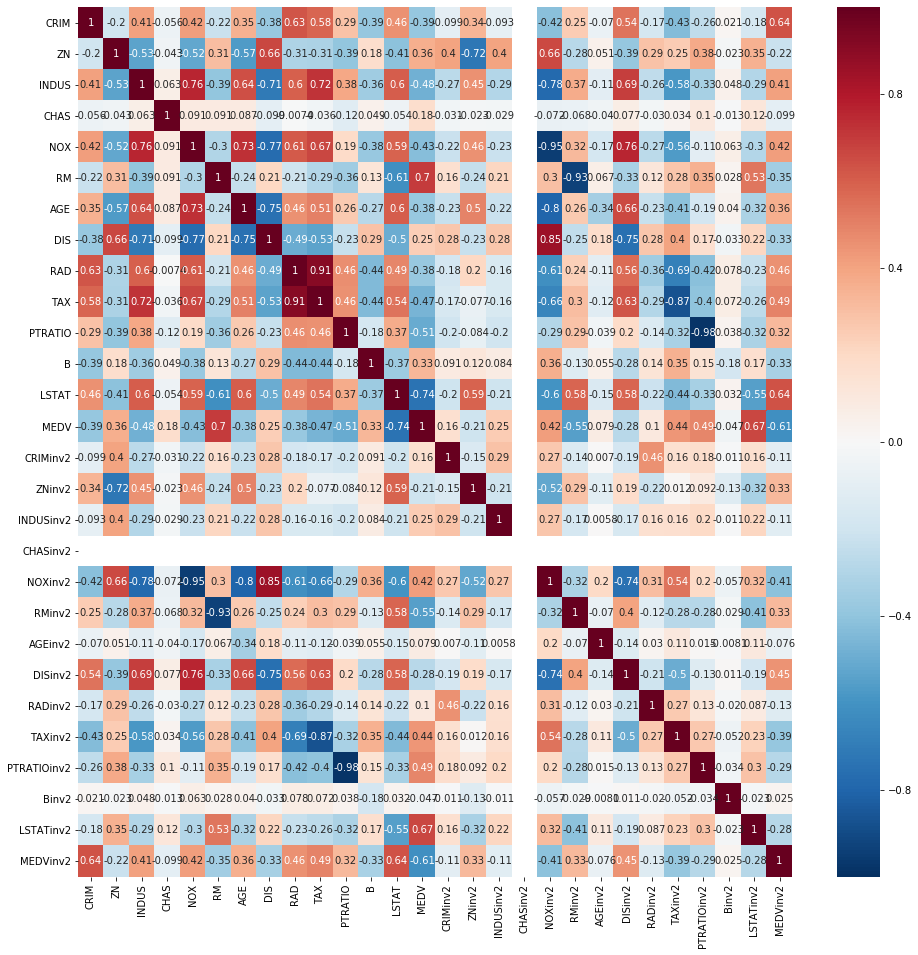

In [421]:
plt.figure(figsize=(16, 16))
ax = sns.heatmap(inverse2_data.corr(), cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Попробуем выявить связь между параметрами вида x^2 (х - признак) и посмотреть на их корелляцию с оригинальными признаками и целевой переменной MEDV.
Если смотреть корелляцию с целевым показателем, то тут прослеживается небольшая положительная связь с RM^2 (0.72) и она чуть больше чем с прото RM (0.7).
Если смотреть на признаки, то достаточно сильная связь между: 
 - TAX и RAD^2 (0.91)
 - RAD и TAX^2 (0.93)

In [422]:
deg2_data = data.copy()
for col_name in list(data.columns):
    name = col_name + 'deg2'
    deg2_data[name] = (data[col_name]*data[col_name])

(28.0, 0.0)

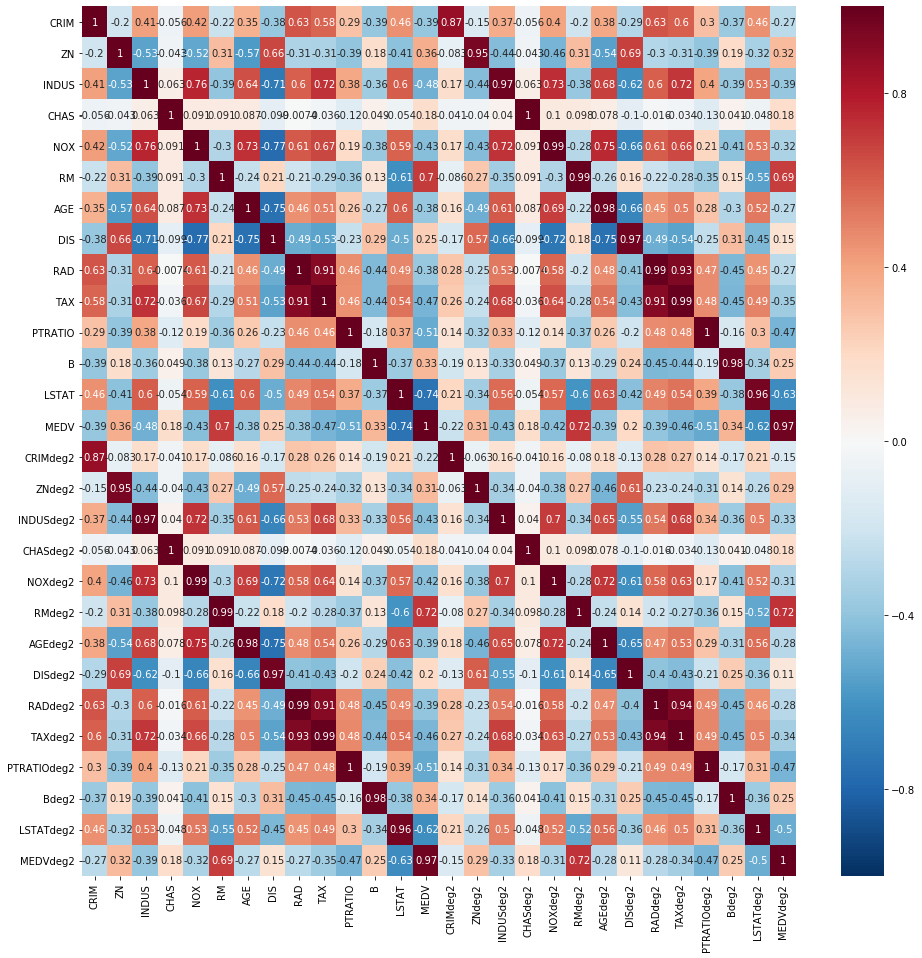

In [423]:
plt.figure(figsize=(16, 16))
ax = sns.heatmap(deg2_data.corr(), cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Попробуем выявить связь между параметрами вида x^3 (х - признак) и посмотреть на их корелляцию с оригинальными признаками и целевой переменной MEDV.
Если смотреть корелляцию с целевым показателем, то тут прослеживается небольшая положительная связь с RM^2 (0.72) и она чуть больше чем с прото RM (0.7)

In [424]:
deg3_data = data.copy()
for col_name in list(data.columns):
    name = col_name + 'deg3'
    deg3_data[name] = (data[col_name]*data[col_name]*data[col_name])

(28.0, 0.0)

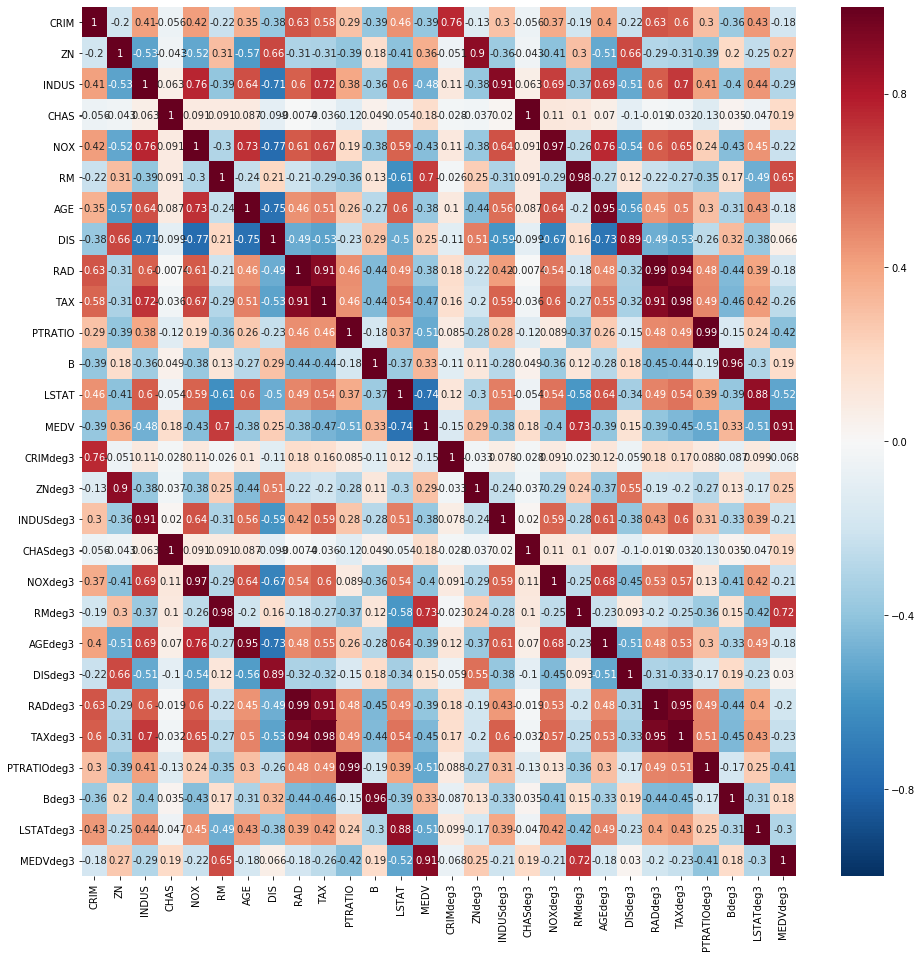

In [425]:
plt.figure(figsize=(16, 16))
ax = sns.heatmap(deg3_data.corr(), cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Попробуем выявить связь между параметрами попарным произведением признаков и целевой переменной MEDV.
Если смотреть корелляцию с целевым показателем, то тут прослеживается:
 - небольшая положительная связь с RM^2 (0.72)
 - небольщая отрицательная связь с NOX*LSTAT (-0.7)
 - небольщая отрицательная связь с RM*LSTAT (-0.73)
 - небольщая отрицательная связь с PTRATIO*LSTAT (-0.75)

In [426]:
mult_data = data[['MEDV']].copy()
length = len(data.columns) -1
start=0
end = 0
for start in range(length):
    for val in list(data.columns[start:length]):
        first_name = data.columns[start]
        second_name = val
        name =  first_name + '*' + second_name
        mult_data[name] = data[first_name]  * data[second_name]


In [427]:
mult_data.corr().head(1)

,MEDV,CRIM*CRIM,CRIM*ZN,CRIM*INDUS,CRIM*CHAS,CRIM*NOX,CRIM*RM,CRIM*AGE,CRIM*DIS,CRIM*RAD,...,TAX*TAX,TAX*PTRATIO,TAX*B,TAX*LSTAT,PTRATIO*PTRATIO,PTRATIO*B,PTRATIO*LSTAT,B*B,B*LSTAT,LSTAT*LSTAT
MEDV,1.0,-0.218837,0.343415,-0.389728,0.142956,-0.397149,-0.372715,-0.384192,-0.414863,-0.3842,...,-0.457047,-0.50882,-0.178412,-0.675416,-0.510658,0.097187,-0.75041,0.33594,-0.527663,-0.622179


(1.5, -0.5)

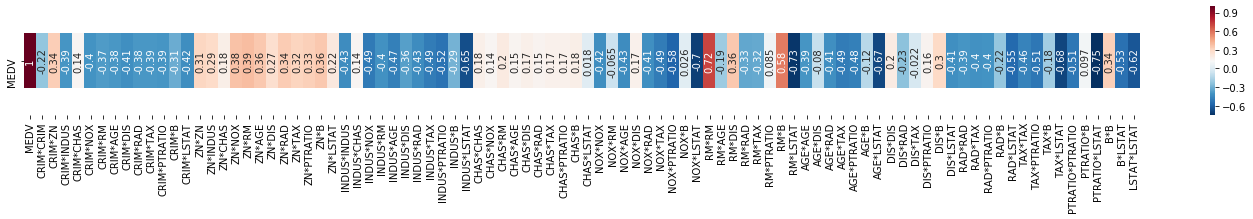

In [428]:
annot_kws={
           'rotation':"vertical",
           'verticalalignment':'center',
           }

plt.figure(figsize=(25, 2))
ax = sns.heatmap(mult_data.corr().head(1), cmap=sns.color_palette("RdBu_r", 1000), annot_kws = annot_kws, annot=True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Попробуем выявить связь между параметрами обратным попарным произведением признаков (1/(x1*x2)) и целевой переменной MEDV.
Если смотреть корелляцию с целевым показателем, то тут прослеживается:
 - небольшая положительная связь с 1 / CHAS*LSTAT (0.83)
 - небольшая положительная связь с 1 / NOX*LSTAT (0.76)
 - небольшая положительная связь с 1 / TAX*LSTAT (0.77)
 - небольшая положительная связь с 1 / PTRATIO*LSTAT (0.81)


In [429]:
invmult_data = data[['MEDV']].copy()
length = len(data.columns) -1
start=0
for start in range(length):
    for val in list(data.columns[start:length]):
        first_name = data.columns[start]
        second_name = val
        name =  first_name + '*' + second_name
        invmult_data[name] = 1 / (data[first_name]  * data[second_name])

(1.5, -0.5)

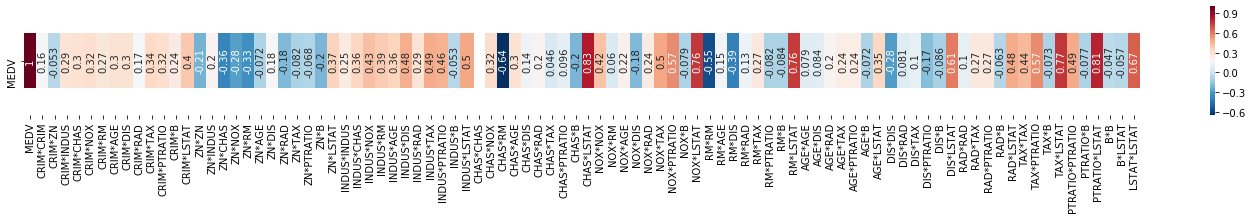

In [430]:
annot_kws={
           'rotation':"vertical",
           'verticalalignment':'center',
           }

plt.figure(figsize=(25, 2))
ax = sns.heatmap(invmult_data.corr().head(1), cmap=sns.color_palette("RdBu_r", 1000), annot_kws = annot_kws, annot=True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Итого дополительные параметры с корелляцией с целевым показателем MEDV:
 - небольшая положительная связь с RM (0.7) 
 - небольщая отрицательная связь  с LSTAT (-0.74)
 
 - небольщая положительная связь с 1/LSTAT (0.8)
 
 - небольшая положительная связь с 1 / CHAS*LSTAT (0.83)
 - небольшая положительная связь с 1 / NOX*LSTAT (0.76)
 - небольшая положительная связь с 1 / TAX*LSTAT (0.77)
 - небольшая положительная связь с 1 / PTRATIO*LSTAT (0.81)
 
 - небольшая положительная связь с RM^2 (0.72)
 - небольщая отрицательная связь с NOX*LSTAT (-0.7)
 - небольщая отрицательная связь с RM*LSTAT (-0.73)
 - небольщая отрицательная связь с PTRATIO*LSTAT (-0.75)
 
ИТОГО ДОБАВИМ признаки (по сути все они лишь немного улучшают прямую связь с LSTAT и большой роли не сыграют):
 - небольщая положительная связь с 1 / LSTAT (0.8)
 - небольшая положительная связь с 1 / PTRATIO*LSTAT (0.81)

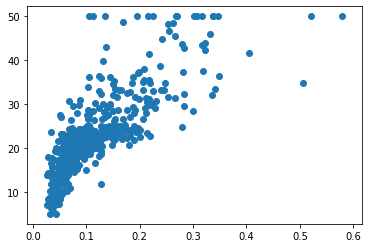

In [431]:
plt.scatter(inverse_data['LSTATinv'], inverse_data['MEDV'])

In [432]:
#попробуем подобрать коэффициенты автоматически с помощью лин регрессии для LSTATinv и MEDV, где LSTATinv = 1/LSTAT
XX = inverse_data[['LSTATinv']].copy()
X_tr_p, X_t_p, y_tr_p, y_t_p = train_test_split(XX, y, test_size=0.3, random_state=0) 
model_p =  LinearRegression()
model_p.fit(X_tr_p, y_tr_p)
model_p.score(X_t_p, y_t_p)

0.6110125772394852

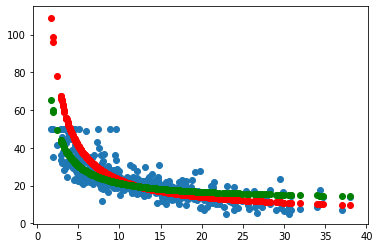

In [433]:

#подберем параметры визуально, чтобы апроксимировать функцию зависимости LSTAT и MEDV
inverse_data['MEDVtarg'] = 180/inverse_data['LSTAT'] + 5
#вычислим целевой знаечение по коэффицинтам линейной регрессии,рассчитаной в предыдущем пунтке
XX['MEDV_'] = model_p.coef_ * XX['LSTATinv'] + model_p.intercept_
plt.scatter(inverse_data['LSTAT'], inverse_data['MEDV'])
plt.scatter(inverse_data['LSTAT'], inverse_data['MEDVtarg'], color = 'red')
plt.scatter(inverse_data['LSTAT'], XX['MEDV_'], color = 'green')

Добавим дополинтельные параметры и посмотрим результат:

In [434]:
Xpara = data[data.columns[:-1]].copy()
y = data[data.columns[-1]]
#Xpara['LSTATmod'] = 180/data['LSTAT'] + 5
Xpara['LSTATautomod'] = model_p.coef_ * 1/data['LSTAT'] + model_p.intercept_
#Xpara['1/PTRATIO*LSTAT'] = 1 / (data['PTRATIO']*data['LSTAT'])

In [435]:
Xpara.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,LSTATautomod
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,30.612774
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,22.163905
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.988700
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,43.493320
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,29.393806


In [436]:
X_tr_para, X_t_para, y_tr_para, y_t_para = train_test_split(Xpara, y, test_size=0.3, random_state=0) 
model_para = LinearRegression()
model_para.fit(X_tr_para, y_tr_para)
model_para.score(X_t_para, y_t_para)

0.7068721538927646

ВЫВОДЫ по добавлению дополнительных параметров показатель R2:
 - с оригинальными параметрами: 0.673382550640018
 - толко с 1/PTRATIO*LSTAT: 0.7026974160291581
 - только с LSTATmod (коэф подобраны визуально): 0.7068721538927646
 - только с LSTATmod (коэа подобраны лин регрессией по LSTAT и MEDV) 0.7068721538927646
 - с обоими параметрами: 0.7052658501778848
 - Поэтому лучше оставить только дополнительный параметр  LSTATmod = (180/LSTAT) + 5 или LSTATautomod

Попробуем применить стандартизацию параметров, то есть привести к виду cо средним значением 0 и стандартым отклонением 1. 
Результат почти не изменился, так как выбросов не очень много.

In [437]:
#Делим данные на признаки и целевую переменную:
Xorig = data[data.columns[:-1]]
y = data[data.columns[-1]]

In [438]:
Xorig.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [439]:
ss_scaler = preprocessing.StandardScaler()
X = ss_scaler.fit_transform(Xorig)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [440]:
model_ss = LinearRegression()
model_ss.fit(X_train, y_train)
model_ss.score(X_test, y_test)

0.6733825506400196

Пробовал поработать с выбросами путем удаления данных за хвантилями 5 и 95, применяя на все признаки, но получается очень много отсеивается данных (80%). возможно можно отсеить и по отдельным параметрам, но думаюется мне большого пирроста это не даст. Лучше использовать другие методы регрессии.

In [441]:
X_tr, X_t, y_tr, y_t = train_test_split(Xorig, y, test_size=0.3, random_state=0)  
model_orig = LinearRegression()
model_orig.fit(X_tr, y_tr)
model_orig.score(X_t, y_t)

0.673382550640018

Попробуем прменить полиномиальную регрессию:
результат хуже, чем в случае применения параметров выше

In [447]:
poly_feat = PolynomialFeatures(degree = 2)
x_poly = poly_feat.fit_transform(Xorig)
x_poly
X_tr_poly, X_t_poly, y_tr_poly, y_t_poly = train_test_split(x_poly, y, test_size=0.3, random_state=0) 

In [448]:
model_poly = LinearRegression()
model_poly.fit(X_tr_poly, y_tr_poly)
model_poly.score(X_t_poly, y_t_poly)

0.6516663767519039

In [444]:
print('coefficient = ', model_poly.coef_, ', intercept = ', model_poly.intercept_)

coefficient =  [-1.70148514e+08 -1.06703412e+00  1.91286809e-01 -6.37864931e+00
  1.53179262e+01 -1.25908377e+01  4.14435399e+00  1.25976596e+00
 -1.14928811e+01  2.35521826e-02  1.09068508e-01  2.29292787e+00
 -1.50210157e-01 -1.53906677e+00  2.36249816e-03  3.03046521e-01
  6.22775623e-01  1.36363921e+00 -1.04001627e-01  6.78571085e-02
 -3.52125882e-03  1.00326623e-01  6.36702617e-01 -4.90572537e-02
  3.20958539e-01 -6.88430552e-05  1.21404542e-02 -1.62288191e-03
 -7.12561942e-03 -7.36393071e-02 -1.65974718e+00  2.96605326e-02
  3.68531348e-04  1.32256087e-03  2.12927098e-03  6.19473024e-04
 -1.15520094e-02  1.26857514e-03 -4.19999961e-03  4.98357335e-02
 -1.77791456e-01  1.19570755e+00  4.18782441e-01  5.10519955e-03
  2.01904238e-01 -3.60069496e-02  1.58285928e-03 -5.22692808e-02
  4.63251508e-03 -1.47499697e-02  1.53179263e+01 -3.44128072e+01
 -6.63717512e+00  6.42381859e-02 -6.51731316e-01  5.06294751e-01
 -1.03977991e-02 -1.15541400e+00  1.49015355e-01 -5.25642592e-01
  4.300302